### Codio Activity 8.7: Evaluating Multiple Models

**Estimated Time: 120 Minutes**

**Total points: 100**

This assignment focuses on solving a specific regression problem using basic cross validation with a train/test/validation split.  In addition to using the methods explored, this assignment also aims to familiarize you with further utilities for data transformation including the `OneHotEncoder` and `OrdinalEncoder` along with their use in a `make_column_transformer`.  

The operations of encoding categorical features will be introduced using `sklearn`.  This will allow you to streamline your model building pipelines.  Depending on whether a string type feature is **ordinal** or **categorical** we want to encode differently.  The `OrdinalEncoder` will be used to encode features that do not need to be binarized due to an underlying order, and `OneHotEncoder` for categorical features (as a similar approach to that of the `.get_dummies()` method in pandas).  By the end of the assignment, you will see how to chain multiple feature encoding methods together including the earlier `PolynomialFeatures` for numeric features. 

<center>
    <img src = images/pipes.png width = 50% />
</center>

#### Index

- [Problem 1](#Problem-1)
- [Problem 2](#Problem-2)
- [Problem 3](#Problem-3)
- [Problem 4](#Problem-4)
- [Problem 5](#Problem-5)
- [Problem 6](#Problem-6)
- [Problem 7](#Problem-7)
- [Problem 8](#Problem-8)
- [Problem 9](#Problem-9)
- [Problem 10](#Problem-10)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn import set_config

set_config(display="diagram") #setting this will display your pipelines as seen above

### The Data: Ames Housing

This dataset is a popular beginning dataset used in teaching regression.  The task is to use specific features of houses to predict the price of the house.  In addition to this, as discussed in video 8.10 -- this dataset is available for use in an ongoing competition where you can use the `test.csv` to submit your models predictions.  Accordingly, the two data files are identical with the exception of the `test.csv` file not containing the target feature.

The data contains 81 columns of different information on the individual houses and their sale price.  A full description of the data is attached [here](data/data_description.txt).  In this assignment, you will use a small subset of the features to begin modeling with that includes ordinal, categorical, and numeric features. As an optional exercise you are encouraged to continue engineering additional features and attempt to improve the performance of your model including submitting the predictions on kaggle. 

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
pd.options.display.max_columns = None

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
#note the difference in one column from train to test
[i for i in train.columns if i not in test.columns]

['SalePrice']

[Back to top](#Index:) 

### Problem 1

#### Train/Test split

**5 Points**

Despite having a test dataset, you want to create a holdout set to assess your models performance.  To do so, use sklearn's `train_test_split` with arguments:

- `test_size = 0.3`
- `random_state = 22`

Assign your results to `X_train, X_test, y_train, y_test` below with `X` and `y` as given.  `X_train` and `X_test` should be a pandas DataFrame, and `y_train`, `y_test` are to be pandas Series.  


In [7]:
X = train.drop('SalePrice', axis = 1)
y = train['SalePrice']

In [8]:
### GRADED

X_train, X_test, y_train, y_test = '', '', '', ''

# YOUR CODE HERE
#raise NotImplementedError()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22, test_size = 0.3)

# Answer check
print(X_train.shape)
print(X_test.shape)
print(type(X_train), type(y_train))#should be DataFrame and Series

(1022, 80)
(438, 80)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


[Back to top](#Index:) 

### Problem 2

#### Baseline Predictions

**10 Points**

Before buildling a regression model, you should set a baseline to compare your later models to.  One way to do this is to guess the mean of the `SalePrice` column.  For the variables `baseline_train` and `baseline_test`, create arrays of same shape as `y_train` and `y_test` respectively.  These should both contain the mean of the target feature in the train set. Use the mean predictions to determine the `mean_squared_error` for both the train and test sets and assign to `mse_baseline_train` and `mse_baseline_test` below.  

In [9]:
### GRADED

baseline_train = ''
baseline_test = ''
mse_baseline_train = ''
mse_baseline_test = ''

# YOUR CODE HERE
#raise NotImplementedError()
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_test = np.ones(shape = y_test.shape)*y_test.mean()
mse_baseline_train = mean_squared_error(baseline_train, y_train)
mse_baseline_test = mean_squared_error(baseline_test, y_test)


# Answer check
print(baseline_train.shape, baseline_test.shape)
print(f'Baseline for training data: {mse_baseline_train}')
print(f'Baseline for testing data: {mse_baseline_test}')

(1022,) (438,)
Baseline for training data: 6277713446.182904
Baseline for testing data: 6374354899.510017


In [10]:
baseline_train

array([180732.9295499, 180732.9295499, 180732.9295499, ...,
       180732.9295499, 180732.9295499, 180732.9295499])

[Back to top](#Index:) 

### Problem 3

#### Examining the Correlations

**5 Points**

What feature has the highest positive correlation with `SalePrice`?  Assign your answer as a string matching the column name exactly to `highest_corr` below.  

In [11]:
train.corr()[['SalePrice']].nlargest(n=2, columns=['SalePrice']).index[1]

'OverallQual'

In [12]:
### GRADED

highest_corr = ''

# YOUR CODE HERE
#raise NotImplementedError()
highest_corr = train.corr()[['SalePrice']].nlargest(n=2, columns=['SalePrice']).index[1]
# Answer check
print(highest_corr)

OverallQual


[Back to top](#Index:) 

### Problem 4

#### Simple Model

**10 Points**


Build a `LinearRegression` model on the training data using only the column `OverallQual`.  Evaluate the mean squared error on both the training and testing data, and assign these to `model_1_train_mse` and `model_1_test_mse` below.    

In [13]:
### GRADED

model_1_train_mse = ''
model_1_test_mse = ''

# YOUR CODE HERE
#raise NotImplementedError()
linear_train = LinearRegression().fit(X_train[['OverallQual']], y_train)
model_1_train_mse = mean_squared_error(y_train, linear_train.predict(X_train[['OverallQual']]))
model_1_test_mse = mean_squared_error(y_test, linear_train.predict(X_test[['OverallQual']]))


# Answer check
print(f'Train MSE: {model_1_train_mse: .2f}')
print(f'Test MSE : {model_1_test_mse: .2f}')

Train MSE:  2269766380.95
Test MSE :  2578831820.35


[Back to top](#Index:) 

### Problem 5

#### Using `OneHotEncoder`

**10 Points**

Similar to the `pd.get_dummies()` method earlier encountered, scikitlearn has a utility for encoding categorical features in the same way.  Below, the `OneHotEncoder` is demonstrated on the `CentralAir` column.  You are to use these results to build a model where the only feature is the `CentralAir` column.  Note the two arguments are used in the `OneHotEncoder`:

- `sparse = False`: returns an array that we can investigate vs with `sparse = True` you are returned a sparse matrix -- a memory saving representation
- `drop = if_binary`: returns a single column for any binary categories.  This avoids reduntant features in our regression model.

Be sure to assign your fit regression model to `model_2`.  Does this model perform better than the baseline model?  

In [14]:
#extract the features
central_air_train = X_train[['CentralAir']]
central_air_test = X_test[['CentralAir']]

In [15]:
#a categorical feature
central_air_train.head()

,CentralAir
1079,Y
601,Y
1015,Y
194,Y
1248,N


In [16]:
#Instantiate a OHE object
#sparse = False returns an array so we can view
ohe = OneHotEncoder(sparse = False, drop='if_binary')
print(ohe.fit_transform(central_air_train)[:5])

[[1.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [17]:
central_air_train

,CentralAir
1079,Y
601,Y
1015,Y
194,Y
1248,N
...,...
356,Y
960,Y
812,N
132,Y


In [18]:
model_2_train = ohe.fit_transform(central_air_train)
model_2_test = ohe.transform(central_air_test)

In [19]:
model_2_train

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]])

In [20]:
model_2_test

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],

In [21]:
### GRADED

model_2 = ''

# YOUR CODE HERE
#raise NotImplementedError()
model_2 = LinearRegression().fit(model_2_train, y_train)
mse_baseline_train = mean_squared_error(y_train, model_2.predict(model_2_train))
mse_baseline_test = mean_squared_error(y_test, model_2.predict(model_2_test))

# Answer check
print(model_2.coef_)
print(mse_baseline_train)
print(mse_baseline_test)

[84484.53030402]
5858728828.045464
6027441846.375812


[Back to top](#Index:) 

### Problem 6

#### Using `make_column_transformer`

**10 Points**


To build a model using both the `OverallQual` column and the `CentralAir` column, you could use the `OneHotEncoder` to transform `CentralAir`, and then concatenate the results back into a DataFrame or numpy array.  To streamline this process, the `make_column_transformer` can be used to seperate specific columns for certain transformations.  Below, a `make_column_transformer` has been created for you to do just this.  


The arguments are tuples of the form `(transformer, columns)` that specify a transformation to perform on the given column.  Further, the `remainder = passthrough` argument says to just pass the other columns through.  You are returned a numpy array with the `CentralAir` column binarized and concatenated to the `OverallQual` feature.


For an example using the `make_column_transformer` see [here](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py).


In [22]:
col_transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['CentralAir']), 
                                          remainder='passthrough')

In [23]:
col_transformer.fit_transform(X_train[['OverallQual', 'CentralAir']])

array([[1., 5.],
       [1., 6.],
       [1., 8.],
       ...,
       [0., 5.],
       [1., 5.],
       [1., 9.]])

Now, you can treat the `col_transformer` as a transformer object and insert it as a step in a `Pipeline`.  Below, create a `Pipeline` with the `col_transformer` as the first step, followed by `LinearRegression` estimator as `pipe_1` below.  Fit and score the pipeline on the columns `['OverallQual', 'CentralAir']`.  Does this model perform better than the baseline? 

- Reminder that steps in a `Pipeline` are tuples with names and objects.  You should name the transformer `col_transformer` and estimator `linreg`.  

In [24]:
### GRADED

pipe_1 = ''

# YOUR CODE HERE
#raise NotImplementedError()
pipe_1 = Pipeline([('col_transformer', col_transformer),
                   ('linreg', LinearRegression())])
pipe_1.fit(X_train[['OverallQual', 'CentralAir']], y_train)

mse_baseline_train = mean_squared_error(y_train, pipe_1.predict(X_train[['OverallQual', 'CentralAir']]))
mse_baseline_test = mean_squared_error(y_test, pipe_1.predict(X_test[['OverallQual', 'CentralAir']]))

# Answer check
print(mse_baseline_train)
print(mse_baseline_test)
print(pipe_1.named_steps)#col_transformer and linreg should be keys
pipe_1

2258964985.0389304
2574719176.7928305
{'col_transformer': ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['CentralAir'])]), 'linreg': LinearRegression()}


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['CentralAir'])])),
                ('linreg', LinearRegression())])

[Back to top](#Index:) 

### Problem 7

#### Using `OrdinalEncoder`

**10 Points**

Not all columns warrant binarization as done on the `CentralAir` column.  For example, consider the `HeatingQC` feature -- representing the quality of the heating in the house.  From the data description the unique values are described as:

```
HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

These are ordered values, and rather than binarizing them a numeric value representing the scale can be used.  For example, using a scale of 0 - 4 you may associate the categories with an order in a list from least to greatest as:

```
['Po', 'Fa', 'TA', 'Gd', 'Ex']
```

Creating an `OrdinalEncoder` with these categories will transform the `HeatingQC` feature mapping each category as

```
Po: 0
Fa: 1
TA: 2
Gd: 3
Ex: 4
```

This is demonstrated below, and in a similar manner the use of the `make_column_transformer` is shown using the three columns `['OverallQual', 'CentralAir', 'HeatingQC']`, applying the appropriate transformations to each column and passing the remaining numeric feature through.  

In [25]:
oe = OrdinalEncoder(categories = [['Po', 'Fa', 'TA', 'Gd', 'Ex']])

In [26]:
oe.fit_transform(X_train[['HeatingQC']])

array([[3.],
       [2.],
       [4.],
       ...,
       [2.],
       [3.],
       [4.]])

In [27]:
X_train['HeatingQC'].head()

1079    Gd
601     TA
1015    Ex
194     TA
1248    Fa
Name: HeatingQC, dtype: object

In [28]:
ordinal_ohe_transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['CentralAir']),
                                          (OrdinalEncoder(categories = [['Po', 'Fa', 'TA', 'Gd', 'Ex']]), ['HeatingQC']),
                                          remainder='passthrough')

In [29]:
ordinal_ohe_transformer.fit_transform(X_train[['OverallQual', 'CentralAir', 'HeatingQC']])[:5]

array([[1., 3., 5.],
       [1., 2., 6.],
       [1., 4., 8.],
       [1., 2., 5.],
       [0., 1., 6.]])

In [30]:
X_train[['OverallQual', 'CentralAir', 'HeatingQC']].head()

,OverallQual,CentralAir,HeatingQC
1079,5,Y,Gd
601,6,Y,TA
1015,8,Y,Ex
194,5,Y,TA
1248,6,N,Fa


You are to build a pipeline incorporating this new transformer and with steps named `transformer` and `linreg`.  Fit and evaluate the model on the training and test set using mean squared error.  Is this model better than the baseline? 

Assign your pipeline to `pipe_2` below and mean squared errors to `pipe_2_train_mse` and `pipe_2_test_mse` as floats below. 

In [31]:
### GRADED

pipe_2 = ''
pipe_2_train_mse = ''
pipe_2_test_mse = ''

# YOUR CODE HERE
#raise NotImplementedError()
pipe_2 = Pipeline([('transformer', ordinal_ohe_transformer),
                   ('linreg', LinearRegression())])
pipe_2.fit(X_train[['OverallQual', 'CentralAir', 'HeatingQC']], y_train)

pipe_2_train_mse = float(mean_squared_error(y_train, pipe_2.predict(X_train[['OverallQual', 'CentralAir', 'HeatingQC']])))
pipe_2_test_mse = float(mean_squared_error(y_test, pipe_2.predict(X_test[['OverallQual', 'CentralAir', 'HeatingQC']])))



# Answer check
print(pipe_2.named_steps)
print(f'Train MSE: {pipe_2_train_mse: .2f}')
print(f'Test MSE : {pipe_2_test_mse: .2f}')
pipe_2

{'transformer': ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['CentralAir']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex']]),
                                 ['HeatingQC'])]), 'linreg': LinearRegression()}
Train MSE:  2211416025.54
Test MSE :  2597701543.40


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['CentralAir']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['HeatingQC'])])),
                ('linreg', LinearRegression())])

[Back to top](#Index:) 

### Problem 8

#### Including `PolynomialFeatures`

**10 Points**

Finally, the earlier transformation of continuous columns using the `PolynomialFeatures` with `degree = 2` can be implemented alongside the `OneHotEncoder` and `OrdinalEncoder`.  

The `make_column_transformer` is again used, and you are to create a `Pipeline` with steps `transformer` and `linreg`.  

The `Pipeline` is fit on the training data using features `['OverallQual', 'CentralAir', 'HeatingQC']`.  

Your task is to determine the mean squared error on the train and test data and assign these as floats to `quad_train_mse` and `quad_test_mse` below.  

In [32]:
poly_ordinal_ohe = make_column_transformer((OrdinalEncoder(categories = [['Po', 'Fa', 'TA', 'Gd', 'Ex']]), ['HeatingQC']),
                                           (OneHotEncoder(drop = 'if_binary'), ['CentralAir']),
                                           (PolynomialFeatures(include_bias = False, degree = 2), ['OverallQual']))
pipe_3 = Pipeline([('transformer', poly_ordinal_ohe), 
                  ('linreg', LinearRegression())])

In [33]:
pipe_3.fit(X_train[['OverallQual', 'CentralAir', 'HeatingQC']], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['HeatingQC']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['CentralAir']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['OverallQual'])])),
                ('linreg', LinearRegression())])

In [34]:
### GRADED

quad_train_mse = ''
quad_test_mse = ''

# YOUR CODE HERE
#raise NotImplementedError()

quad_train_mse = float(mean_squared_error(y_train, pipe_3.predict(X_train[['OverallQual', 'CentralAir', 'HeatingQC']])))
quad_test_mse = float(mean_squared_error(y_test, pipe_3.predict(X_test[['OverallQual', 'CentralAir', 'HeatingQC']])))

# Answer check
print(f'Train MSE: {quad_train_mse: .2f}')
print(f'Test MSE : {quad_test_mse: .2f}')

Train MSE:  1856951076.95
Test MSE :  2207864528.17


[Back to top](#Index:) 

### Problem 9

#### Including More Features

**20 Points**

Use the following features to build a new `make_column_transformer` and fit 5 different models of degree 1 - 5 using the `degree` argument in your `PolynomialFeatures` transformer.  Keep track of the subsequent train mean squared error and test set mean squared error with the lists `train_mses` and `test_mses` respectively.  

The `poly_ordinal_ohe` object contains the different transformers needed.  Note that rather than passing a list of columns to the `PolynomialFeatures` transformer, the `make_column_selector` function is used to select any numeric feature.  For more information on the `make_column_selector` see [here](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html).



In [35]:
features = ['CentralAir', 'HeatingQC', 'OverallQual', 'GrLivArea', 'KitchenQual', 'FullBath']

In [36]:
X_train[features].head()

,CentralAir,HeatingQC,OverallQual,GrLivArea,KitchenQual,FullBath
1079,Y,Gd,5,990,TA,1
601,Y,TA,6,1375,Gd,1
1015,Y,Ex,8,1665,Gd,2
194,Y,TA,5,864,TA,1
1248,N,Fa,6,2058,TA,1


In [37]:
poly_ordinal_ohe = make_column_transformer((PolynomialFeatures(), make_column_selector(dtype_include=np.number)),
                                           (OrdinalEncoder(categories = [['Po', 'Fa', 'TA', 'Gd', 'Ex']]), ['HeatingQC', 'KitchenQual']),
                                               (OneHotEncoder(drop = 'if_binary', sparse = False), ['CentralAir']))

In [38]:
### GRADED

train_mses = []
test_mses = []
#for degree in 1 - 5
for i in range(1, 6):
    #create pipeline with PolynomialFeatures degree i 
    #ADD APPROPRIATE ARGUMENTS IN POLYNOMIALFEATURES
    poly_ordinal_ohe = make_column_transformer((PolynomialFeatures(), make_column_selector(dtype_include=np.number)),
                                           (OrdinalEncoder(categories = [['Po', 'Fa', 'TA', 'Gd', 'Ex']]), ['HeatingQC']),
                                               (OneHotEncoder(drop = 'if_binary'), ['CentralAir']))
    
    
    #fit on train

    #predict on train and test

    #compute mean squared errors
    
    #append to train_mses and test_mses respectively

# YOUR CODE HERE
#raise NotImplementedError()
for i in range(1, 6):
    #create pipeline with PolynomialFeatures degree i 
    #ADD APPROPRIATE ARGUMENTS IN POLYNOMIALFEATURES
    poly_ordinal_ohe = make_column_transformer((PolynomialFeatures(degree = i), make_column_selector(dtype_include=np.number)),
                                           (OrdinalEncoder(categories = [['Po', 'Fa', 'TA', 'Gd', 'Ex']]), ['HeatingQC']),
                                               (OneHotEncoder(drop = 'if_binary'), ['CentralAir']))
    
    pipe = Pipeline([('transformer', poly_ordinal_ohe),
                     ('linreg', LinearRegression())])
    #fit on train
    pipe.fit(X_train[features], y_train)

    #predict on train and test

    #compute mean squared errors
    p1 = pipe.predict(X_train[features])
    p2 = pipe.predict(X_test[features])
    #predict on train and test
    train_mses.append(mean_squared_error(y_train, p1))
    test_mses.append(mean_squared_error(y_test, p2))

# YOUR CODE HERE


# Answer check
print(train_mses)
print(test_mses)
pipe

[1635858627.9553099, 1281188434.12774, 1175803979.7815204, 1182776263.2373707, 1145465695.4176936]
[2038392771.0031424, 1391506503.502298, 6994945784.919496, 180610468292.76385, 1229606173986.2007]


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=5),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faf90d0a340>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['HeatingQC']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['CentralAir'])])),
                ('linreg', LinearRegression())])

The Complexity that minimized Test Error was: 2


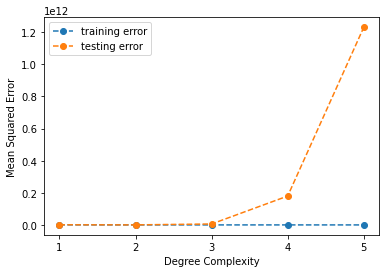

In [39]:
print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
plt.plot(range(1, 6), train_mses, '--o', label = 'training error')
plt.plot(range(1, 6), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, 6), range(1, 6))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend()

[Back to top](#Index:) 

### Problem 10

#### Optimal Model Complexity 

**10 Points**

Based on your models mean squared error on the testing data in **Problem 9** above, what was the optimal complexity?  Assign your answer as an integer to `best_complexity` below.  Compute the **MEAN SQUARED ERROR** of this model and assign to `best_mse` as a float. 

In [40]:
test_mses.index(min(test_mses)) + 1

2

In [41]:
### GRADED

best_complexity = ''
best_mse = ''

# YOUR CODE HERE
#raise NotImplementedError()
best_complexity = test_mses.index(min(test_mses)) + 1
best_mse = min(test_mses)

# Answer check
print(f'The best degree polynomial model is:  {best_complexity}')
print(f'The smallest mean squared error on the test data is : {best_mse: .2f}')

The best degree polynomial model is:  2
The smallest mean squared error on the test data is :  1391506503.50


### Further Exploration

This activity was meant to introduce you to a more streamlined modeling process using the `sklearn` library.  While your models should be performing better than the baseline, it is likely that with a bit more feature engineering and cross validation you would be able to further improve the performance.  You are encouraged to explore further feature engineering and encoding, particularly with handling missing values.  

Additionally, other transformations on the data may be appropriate.  For example, if you look at the distribution of errors in your model, you will note that they are slightly skewed.  An assumption of a Linear Regression model is that these should be roughly normally distributed.  By building a model on the logarithm of the target column, and evaluating the model on the logarithm of the testing data you will improve towards this assumption.  Note that the actual kaggle exercise is judged on the **ROOT MEAN SQUARED ERROR** of the logarithm of the target feature. 

If interested, scikitlearn also provides a function `TransformedTargetRegressor` that will accomplish this transformation and can easily be added to a pipeline. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html) for more information on this transformer. 